# Training Model and Inference

## Prepration

**Requirments for training on python==3.11**

```
    pandas==2.2.2
    numpy==1.26.4
    sklearn-pandas==2.2.0
    matplotlib==3.10.0
    pydantic==2.10.6
    sentence-transformers==3.4.1
    transformers==4.48.2
    kaleido==0.2.1
    datasets==3.2.0
    regex==2024.11.6
    requests==2.32.3
    plotly==5.24.1
```

In [1]:
%cd /content/drive/MyDrive/Projects/crypto-sentiment

/content/drive/MyDrive/Projects/crypto-sentiment


In [ ]:
!pip install -U kaleido

In [ ]:
!pip install datasets regex unidecode -q

In [4]:
%ls data

processed/  raw/  result/


## Train and testing related funtions
- cleaning functions
- loading model
- predicting


In [5]:
MODEL_NAME = "ElKulako/cryptobert"
NUM_LABEL = 3

In [6]:
import re
import regex
import unicodedata


def replace_urls(text: str) -> str:
    tco_pattern = r'https://t\.co/\w+'
    text = re.sub(tco_pattern, ' TWITTER URL ', text)
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, 'URL', text)
    return text


def normalize_text(text: str) -> str:
    # Normalize stylistic variants (e.g., "𝘵" → "t") using NFKC
    text = unicodedata.normalize('NFKC', text)
    # Decompose characters into base + combining marks (e.g., "í" → "i" + "◌́")
    text = unicodedata.normalize('NFKD', text)
    # Remove combining diacritical marks (e.g., accents, graves)
    text = regex.sub(r'\p{Mn}', '', text)

    return text


def normalize_whitespace(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r' {3,}', ' ', text)
    return text.strip()



def clean(text: str) -> str:
    text = replace_urls(text)
    text = normalize_text(text)
    text = normalize_whitespace(text)
    return text

In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from transformers import TextClassificationPipeline


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABEL)


def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, max_length=64, padding="max_length")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average='weighted'),
        "recall": recall_score(labels, predictions, average='weighted'),
        "f1": f1_score(labels, predictions, average='weighted')
    }


def predict_sentiment(texts, pipe):

    outputs = []
    results = pipe(texts, batch_size=8)

    for text, scores in zip(texts, results):
        predicted_entry = max(scores, key=lambda x: x["score"])
        predicted_label = predicted_entry["label"]

        bullish_score = next((entry["score"] for entry in scores if entry["label"].lower() == "bullish"), 0.0)
        bearish_score = next((entry["score"] for entry in scores if entry["label"].lower() == "bearish"), 0.0)

        sentiment_index = bullish_score - bearish_score

        outputs.append({
            "predicted_label": predicted_label,
            "sentiment_index": sentiment_index
        })
    return outputs

def inference_on_test(test_path, result_path, report=False, model_name=None):

    if model_name:
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

    pipe = TextClassificationPipeline(
        model=model,
        tokenizer=tokenizer,
        max_length=64,
        truncation=True,
        padding="max_length",
        return_all_scores=True
    )

    test_df = pd.read_csv(test_path)

    test_df["clean_text"] = test_df["text"].apply(clean)
    texts = test_df["clean_text"].tolist()

    predictions = predict_sentiment(texts, pipe)

    pred_df = pd.DataFrame(predictions)
    # pred_df.to_csv(result_path, index=False)

    result_df = pd.concat([test_df, pred_df], axis=1)
    result_df.to_csv(result_path, index=False)

    print(f"Predictions saved to {result_path}!")

    if report:
        label_mapper = {
            0: 'Bearish',
            1: 'Neutral',
            2: 'Bullish'
        }
        true_labels = test_df["label"].tolist()
        true_labels = [label_mapper[label] for label in true_labels]

        predicted_labels = pred_df["predicted_label"].tolist()
        cm = confusion_matrix(true_labels, predicted_labels)
        cls_report = classification_report(true_labels, predicted_labels)
        print("Confusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(cls_report)

    return result_df


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/932 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [8]:
model.config

RobertaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "ElKulako/cryptobert",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Bearish",
    "1": "Neutral",
    "2": "Bullish"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Bearish": 0,
    "Bullish": 2,
    "Neutral": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.48.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

# Run 1

In [ ]:
vr = 1
# train_path = "./data/processed/train.csv"
# val_path = './data/processed/val.csv'
# test_path = './data/processed/test.csv'
train_path = './data/processed/train_augmented.csv'
val_path = './data/processed/val_augmented.csv'
test_path = './data/processed/test_augmented.csv'
test_result_path = f'./data/result/test_result_{vr}.csv'
result_path = f"./vr-{vr}/results"
save_path = f"./vr-{vr}/saved-model"
EPOCH = 5
%mkdir vr-1

In [12]:
dataset = load_dataset("csv", data_files={"train": train_path, "validation": val_path})
tokenized_datasets = dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir=result_path,
    num_train_epochs=EPOCH,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to=[],
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=True,
    save_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2357 [00:00<?, ? examples/s]

Map:   0%|          | 0/334 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-d4cbd48c04ed>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.587156,0.766467,0.771091,0.766467,0.766677
2,No log,0.562270,0.808383,0.807428,0.808383,0.807612
3,No log,0.742552,0.799401,0.803763,0.799401,0.800540
4,0.372200,0.899390,0.808383,0.811441,0.808383,0.808854
5,0.372200,0.949176,0.811377,0.811513,0.811377,0.811234


('./vr-1/saved-model/tokenizer_config.json',
 './vr-1/saved-model/special_tokens_map.json',
 './vr-1/saved-model/vocab.json',
 './vr-1/saved-model/merges.txt',
 './vr-1/saved-model/added_tokens.json',
 './vr-1/saved-model/tokenizer.json')

In [11]:
model.config

RobertaConfig {
  "_name_or_path": "ElKulako/cryptobert",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Bearish",
    "1": "Neutral",
    "2": "Bullish"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Bearish": 0,
    "Bullish": 2,
    "Neutral": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.48.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

### Push model to Huggingface

In [16]:
from huggingface_hub import login

login()

In [17]:
username = 'fatemenajafi135'
model_name = 'crypto-tweet-sentiment'

In [18]:
from huggingface_hub import HfApi

api = HfApi()
api.create_repo(model_name, private=True)

RepoUrl('https://huggingface.co/fatemenajafi135/crypto-tweet-sentiment', endpoint='https://huggingface.co', repo_type='model', repo_id='fatemenajafi135/crypto-tweet-sentiment')

In [19]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model.push_to_hub(f"{username}/{model_name}")
tokenizer.push_to_hub(f"{username}/{model_name}")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/fatemenajafi135/crypto-tweet-sentiment/commit/04257e9fea8f52bb006aca87c7685d7c65d3d470', commit_message='Upload tokenizer', commit_description='', oid='04257e9fea8f52bb006aca87c7685d7c65d3d470', pr_url=None, repo_url=RepoUrl('https://huggingface.co/fatemenajafi135/crypto-tweet-sentiment', endpoint='https://huggingface.co', repo_type='model', repo_id='fatemenajafi135/crypto-tweet-sentiment'), pr_revision=None, pr_num=None)

### Predictions on testset

In [20]:
# prediction in testset

pred = inference_on_test(test_path, test_result_path, report=True, model_name=save_path)


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Predictions saved to ./data/result/test_result_1.csv!
Confusion Matrix:
[[ 36   6  11]
 [  4 101  15]
 [  8  19 134]]

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.75      0.68      0.71        53
     Bullish       0.80      0.84      0.82       120
     Neutral       0.84      0.83      0.83       161

    accuracy                           0.81       334
   macro avg       0.80      0.78      0.79       334
weighted avg       0.81      0.81      0.81       334


In [21]:
eth_path = "./data/raw/ETH_data.csv"
eth_result_path = "./data/result/eth_result.csv"

pred = inference_on_test(eth_path, eth_result_path, model_name=save_path, report=False)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Predictions saved to ./data/result/eth_result.csv!


# Run 2

In [ ]:
vr = 2
train_path = "./data/processed/train.csv"
val_path = './data/processed/val.csv'
test_path = './data/processed/test.csv'
test_result_path = f'./data/result/test_result_{vr}.csv'
result_path = f"./vr-{vr}/results"
save_path = f"./vr-{vr}/saved-model"
%mkdir vr-2

mkdir: cannot create directory ‘vr-2’: File exists


In [ ]:
dataset = load_dataset("csv", data_files={"train": train_path, "validation": val_path})
tokenized_datasets = dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir=result_path,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to=[],
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1556 [00:00<?, ? examples/s]

Map:   0%|          | 0/334 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

<ipython-input-111-3e831624656e>:19: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.551852,0.796407,0.798860,0.796407,0.793015
2,No log,0.546433,0.802395,0.805164,0.802395,0.803045
3,No log,0.566809,0.808383,0.807944,0.808383,0.808021


('./vr-2/saved-model/tokenizer_config.json',
 './vr-2/saved-model/special_tokens_map.json',
 './vr-2/saved-model/vocab.json',
 './vr-2/saved-model/merges.txt',
 './vr-2/saved-model/added_tokens.json',
 './vr-2/saved-model/tokenizer.json')

In [ ]:
# prediction in testset

pred = inference_on_test(test_path, test_result_path, report=True, model_name=save_path)


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



Predictions saved to ./data/result/test_result_2.csv!
Confusion Matrix:
[[ 38   5  10]
 [  3  91  26]
 [  5  19 137]]

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.83      0.72      0.77        53
     Bullish       0.79      0.76      0.77       120
     Neutral       0.79      0.85      0.82       161

    accuracy                           0.80       334
   macro avg       0.80      0.78      0.79       334
weighted avg       0.80      0.80      0.80       334


In [ ]:
eth_path = "./data/raw/ETH_data.csv"
eth_result_path = "./data/result/eth_result_vr-2.csv"

pred = inference_on_test(eth_path, eth_result_path, model_name=save_path, report=False)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



Predictions saved to ./data/result/eth_result_vr-2.csv!


# Inferencing on ETH data

In [1]:
import pandas as pd

In [ ]:
# If already tested
eth_result_path = "./data/result/eth_result.csv"
eth_result = pd.read_csv(eth_result_path)

# if not!
# eth_result_path = "./data/result/eth_result.csv"
# eth_path = "./data/raw/ETH_data.csv"
# pred = inference_on_test(eth_path, eth_result_path, model_name=save_path, report=False)

In [ ]:
import pandas as pd
import requests
import time

def fetch_eth_data(start_date, end_date):
    base_url = "https://api.binance.com/api/v3/klines"

    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    params = {
        "symbol": "ETHUSDT",
        "interval": "1d",
        "startTime": start_timestamp,
        "endTime": end_timestamp,
        "limit": 1000
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', '_', '_', '_', '_', '_', '_']
    eth_df = pd.DataFrame(data, columns=columns)

    eth_df['date'] = pd.to_datetime(eth_df['timestamp'], unit='ms').dt.date

    eth_df[['open', 'high', 'low', 'close', 'volume']] = eth_df[['open', 'high', 'low', 'close', 'volume']].astype(float)

    eth_df = eth_df[['date', 'open', 'high', 'low', 'close', 'volume']]
    eth_df['volume'] = eth_df['volume'].astype(float)
    return eth_df

eth_price = fetch_eth_data("2024-12-15", "2025-01-13")
eth_price.to_csv("./data/raw/eth_price.csv")


In [ ]:
eth_price = pd.read_csv("./data/raw/eth_price.csv")
eth_price.head()

,Unnamed: 0,date,open,high,low,close,volume
0,0,2024-12-15,3870.30,3974.61,3831.50,3959.09,2.538332e+05
1,1,2024-12-16,3959.09,4107.80,3884.00,3986.24,6.733511e+05
2,2,2024-12-17,3986.24,4041.82,3847.96,3893.01,4.508260e+05
3,3,2024-12-18,3893.01,3907.19,3617.42,3626.80,7.225051e+05
4,4,2024-12-19,3626.80,3720.00,3326.80,3417.01,1.078153e+06


In [ ]:
eth_result.head()

,id,text,sentiment_analysis,detected_symbols,clean_text,predicted_label,sentiment_index,date
0,7904170,𝗔𝗻𝗼𝘁𝗵𝗲𝗿 𝗮𝗶𝗿𝗱𝗿𝗼𝗽 𝘁𝘂𝘁𝗼𝗿𝗶𝗮𝗹 𝘀𝗵𝗮𝗿𝗲𝗱 𝗯𝘆 𝗰𝗼𝗺𝗺𝘂𝗻𝗶𝘁𝘆 𝗺...,2024-12-22 13:24:11+00:00,"['ETH', 'USDC', 'ENA', 'HYPE', 'USUAL', 'USR']",Another airdrop tutorial shared by community m...,Bullish,0.941565,2024-12-22
1,7400934,really want to see us take a crack at 3k ETH b...,2024-12-20 10:52:51+00:00,['ETH'],really want to see us take a crack at 3k ETH b...,Neutral,0.001954,2024-12-20
2,12608909,"Back in a half risk $ETH long.\n\nEntry 3250~,...",2025-01-11 11:03:23+00:00,['ETH'],"Back in a half risk $ETH long. Entry 3250~, SL...",Neutral,0.019489,2025-01-11
3,8855541,BREAKING: @pumpdotfun FLIPS ETHEREUM IN 24H RE...,2024-12-28 03:26:12+00:00,['ETH'],BREAKING: @pumpdotfun FLIPS ETHEREUM IN 24H RE...,Bullish,0.999154,2024-12-28
4,9486940,BASE.ETH,2024-12-31 05:44:23+00:00,['ETH'],BASE.ETH,Neutral,0.001368,2024-12-31


In [7]:
import pandas as pd
import matplotlib.pyplot as plt


eth_result['date'] = pd.to_datetime(eth_result['sentiment_analysis'])
eth_result['date'] = eth_result['date'].dt.date


df_daily_avg = eth_result.groupby(eth_result['date'])['sentiment_index'].mean()
df_daily_avg.head()

,sentiment_index
date,
2024-12-15,0.421222
2024-12-16,0.421812
2024-12-17,0.335599
2024-12-18,0.384695
2024-12-19,0.244320


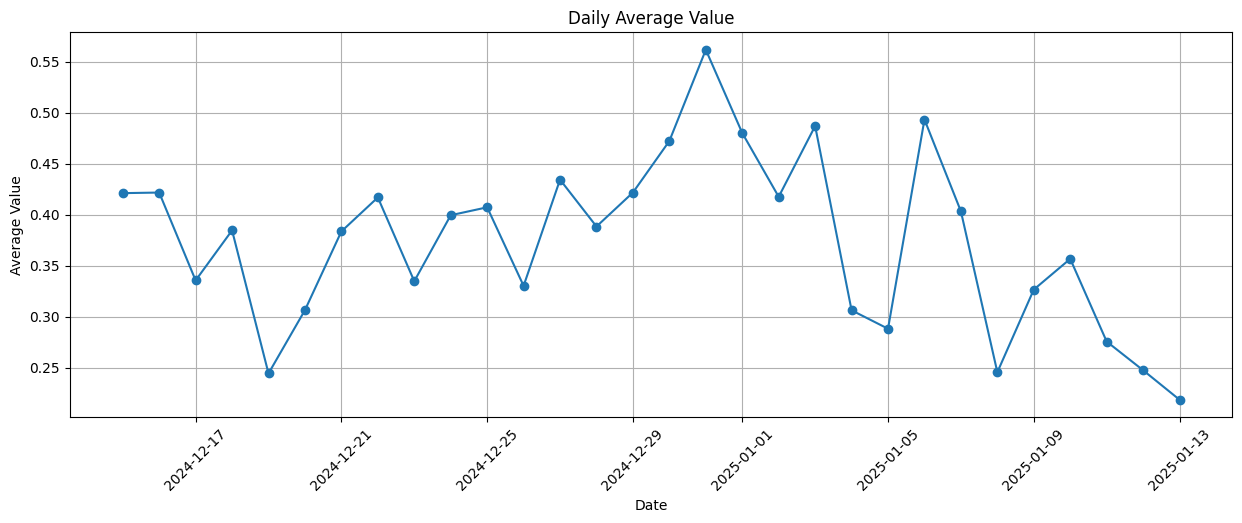

In [8]:
# Plot
plt.figure(figsize=(15, 5))
df_daily_avg.plot(marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.title('Daily Average Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [9]:
eth_price['date'] = pd.to_datetime(eth_price['date'])
eth_price['date'] = eth_price['date'].dt.date
eth_price.set_index('date', inplace=True)
eth_price.drop(columns=['Unnamed: 0'], inplace=True)
eth_price.head()

,open,high,low,close,volume
date,,,,,
2024-12-15,3870.30,3974.61,3831.50,3959.09,2.538332e+05
2024-12-16,3959.09,4107.80,3884.00,3986.24,6.733511e+05
2024-12-17,3986.24,4041.82,3847.96,3893.01,4.508260e+05
2024-12-18,3893.01,3907.19,3617.42,3626.80,7.225051e+05
2024-12-19,3626.80,3720.00,3326.80,3417.01,1.078153e+06


In [10]:
df_daily = df_daily_avg.to_frame()
price_and_sentiment_df = pd.concat([eth_price, df_daily], axis=1)
price_and_sentiment_df.head(5)

,open,high,low,close,volume,sentiment_index
date,,,,,,
2024-12-15,3870.30,3974.61,3831.50,3959.09,2.538332e+05,0.421222
2024-12-16,3959.09,4107.80,3884.00,3986.24,6.733511e+05,0.421812
2024-12-17,3986.24,4041.82,3847.96,3893.01,4.508260e+05,0.335599
2024-12-18,3893.01,3907.19,3617.42,3626.80,7.225051e+05,0.384695
2024-12-19,3626.80,3720.00,3326.80,3417.01,1.078153e+06,0.244320


In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_dual_chart(df, float_column):

    fig = make_subplots(rows=2, cols=1,
                       shared_xaxes=True,
                       vertical_spacing=0.05,
                       row_heights=[0.7, 0.3])

    # Add candlestick chart
    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df['open'],
            high=df['high'],
            low=df['low'],
            close=df['close'],
            name='Candlesticks'
        ),
        row=1, col=1
    )

    # Add line plot
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[float_column],
            name=float_column,
            line=dict(color='rgba(75, 192, 192, 1)')
        ),
        row=2, col=1
    )

    fig.update_layout(
        title='Price and Sentiment Index',
        yaxis_title='Price ($)',
        yaxis2_title='Sentiment Index',
        xaxis_rangeslider_visible=False,
        height=800,
        showlegend=True
    )

    return fig


fig = create_dual_chart(price_and_sentiment_df, 'sentiment_index')
fig.show()
fig.write_image("chart.png")
fig.write_html("chart.html")

In [ ]:
eth_result_path = "./data/result/eth_result_vr-2.csv"